# Assignment 1: Chemoinformatics - Andrew Cohen
### Exploring a few different machine learning models through predicting the band gap energy of molecules from their molecular structure

In [2]:
#ALL OF THE IMPORTS!!
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_absolute_error
from mordred import Calculator, descriptors
from rdkit import Chem
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from rdkit import DataStructs
from rdkit.Chem import AllChem
from tqdm import tqdm
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

Process Molecule Data from **QM9**

In [3]:
#Load molecules from QM9 Database
data = pd.read_json('C:/Users/ascoh/Desktop/UChicago/Academics/2020-21/Q2 2021/AI for MatSci/qm9.json.gz', lines=True)
print(f'Loaded {len(data)} molecules')

Loaded 25000 molecules


In [4]:
#Parse QM9 data into RDKit Objects
data['mol'] = data['smiles_0'].apply(Chem.MolFromSmiles)

**Mordred** Calculator/Descriptor

In [5]:
#Initiate Mordred Descriptor Calculator
calc = Calculator(descriptors, ignore_3D=True)

In [6]:
#Compute Mordred Descriptors for QM9 Molecules and save into Panda df
desc = calc.pandas(data['mol'])
print(f'Computed {len(desc.columns)} descriptors for {len(desc)} molecules')

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [14:13<00:00, 29.28it/s]


Computed 1613 descriptors for 25000 molecules


Reducing Dimensionality of Desc

In [7]:
#Removing Null Data from Desc DF and converting to Float64                           

for c in desc.columns:
    desc[c] = pd.to_numeric(desc[c], errors='coerce')

missing_values = desc.isnull().any() #Identify all rows with missing values in desc
print(f'Found {missing_values.sum()} columns with missing values')

desc = desc.loc[:, ~missing_values]  # Gets only rows that do not (~ means not) have missing values
print(f'New shape: {desc.shape}')


desc.astype('float64').dtypes #Convert Desc df to all floats

Found 546 columns with missing values
New shape: (25000, 1067)


ABC         float64
ABCGG       float64
nAcid       float64
nBase       float64
SpAbs_A     float64
             ...   
WPath       float64
WPol        float64
Zagreb1     float64
Zagreb2     float64
mZagreb2    float64
Length: 1067, dtype: object

In [8]:
desc.sample(5, axis=1).describe()

,AATSC2pe,ATSC2dv,LogEE_Dzv,AATS0se,ATSC4pe
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,-0.002400,-8.980160,19.172283,7.788579,-0.480245
std,0.026068,16.973053,3.249823,0.441260,0.884661
min,-0.116386,-64.000000,0.546177,6.923977,-10.138842
25%,-0.016067,-20.205746,17.215982,7.495503,-0.974112
50%,-0.004065,-10.942766,18.941687,7.719562,-0.403839
75%,0.007353,0.181761,21.005767,8.025415,0.051147
max,0.323606,104.750000,34.753983,12.213778,4.330262


In [9]:
#Scale the Data to Prevent Wild Variation in Data
scaler = StandardScaler()
feats = scaler.fit_transform(desc)

Create a test set of 2000 moleculues. Train a **LassoCV model** using the features with and without reducing the dimensionality to **8 features** using **PCA**

In [10]:
train_data, test_data, train_desc, test_desc = train_test_split(data, desc, test_size=0.08)

In [11]:
#Create the Lasso w/out PCA Pipeline
no_pca_model = Pipeline([
    ('scale', StandardScaler()),
    ('lasso', LassoCV())
])

test_data = test_data.copy()  # Avoids some pandas issues
test_data['no_pca-model'] = no_pca_model.fit(train_desc, train_data['bandgap']).predict(test_desc)

C:\Users\ascoh\Anaconda3\envs\molml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005052284916036598, tolerance: 0.004087048508789349
  tol, rng, random, positive)
C:\Users\ascoh\Anaconda3\envs\molml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008250639126693216, tolerance: 0.004087048508789349
  tol, rng, random, positive)
C:\Users\ascoh\Anaconda3\envs\molml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0062727193184537455, tolerance: 0.004089932172212174
  tol, rng, random, positive)
C:\Users\ascoh\Anaconda3\envs\molml\lib\site-packages\sklearn\linear_model\_coordinate_descent.p

In [12]:
#Create the Lasso w/ PCA Pipeline
pca_model = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=8)),
    ('lasso', LassoCV())
])

test_data['pca-model'] = pca_model.fit(train_desc, train_data['bandgap']).predict(test_desc)
#No Convergence Issues

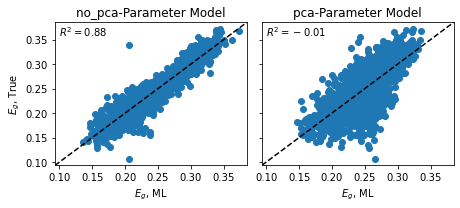

In [13]:
#Plotting the Lasso model w/ and w/out PCA reduction
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6.5, 3.))

# Plot both models
for ax, col in zip(axs, ['no_pca-model', 'pca-model']):
    ax.set_title(f'{col.split("-")[0]}-Parameter Model')
    r2 = r2_score(test_data[col], test_data['bandgap'])
    ax.text(0.02, 0.9, f'$R^2 = {r2:.2f}$', transform=ax.transAxes)
    ax.scatter(test_data[col], test_data['bandgap'])
    
for ax in axs:
    ax.set_xlabel('$E_g$, ML')
    
    ax.set_ylim(ax.get_ylim())
    ax.set_xlim(ax.get_ylim())
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
    
axs[0].set_ylabel('$E_g$, True')
fig.tight_layout()

Train a RandomForest model using the default settings. Plot the change in mean absolute error (MAE) with respect to training set sizes: 10, 100, 1000, 10000 

In [14]:
#RANDOM FOREST
# Instantiate model with 100 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 0, n_jobs=-1)
# Train the model on training data
rf_train_data, rf_test_data, rf_train_desc, rf_test_desc = train_test_split(data, desc)
results=[]

for i in tqdm((10, 100, 1000, 10000)): #Cycle through the differet training set sizes
    rf_subset_desc = rf_train_desc.sample(i)
    rf_subset_data = rf_train_data.sample(i)
    rf.fit(rf_subset_desc, rf_subset_data['bandgap'])
    rf_pred=rf.predict(rf_test_desc);
    results.append({
                'train_size': i,
                'mae': mean_absolute_error(rf_test_data['bandgap'], rf_pred)
            })
results = pd.DataFrame(results)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [08:36<00:00, 129.12s/it]


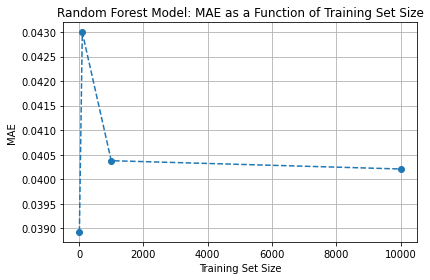

In [15]:
#Plot the RandomForest Model: Training Set Size vs. MAE
fig, ax = plt.subplots()

ax.plot(results['train_size'],results['mae'], 'o--')
ax.set_ylabel('MAE')
ax.set_xlabel('Training Set Size')
ax.set_title('Random Forest Model: MAE as a Function of Training Set Size')

ax.grid(True)
fig.tight_layout()

## Q1-1

*How do the results compare?*

As seen in the graph above, while the MAE begins at about 0.041 (set=10 molecules), it quickly rises to 0.045 upon increasing the training set to 100.As the training set is increased beyond 100 molecules, the MAE linearly decreases.


*Why do some models continue to improve at large training set sizes while others do not?*

Models improve or decline in performance as the training set size increases due to the nature of the model. RandomForest improves as training sets become larger because they perform bootstrapping. Bootstrapping is a method where the model splits the training data into multiple bagged decision trees. The final prediction of the model is an average of the results of these various trees. Having a small number of trees often leads to overfitting. Thus, by increasing the data set the model is able to produce more trees and produce more accurate preditions that can match the complexisty of the system being studied.

A Lasso Model with improper feature selection can lead to overfitting of the data or skews in the model due to outliers. In the lasso model above there is a drastic decrease in the R<sup>2</sup> value when PCA is applied. This is likely because the PCA feature selection reduces the features available to the model to such a degree that lasso can no longer generate an accurate prediction.

It should be noted that both models performed well on small data sets.

With all maching learning models it is important to tune the hyperparameters and apply the proper feature selection in order to optimize model performance. Too much or not enough data results in a poor model.

---

Train the **LASSO** without PCA (using coefficients) and **RandomForest** models (using the assigned feature scores) on **10<sup>4</sup> data points**

In [16]:
#Training a New Lasso w/out PCA model and a new RF model on 10^4 molecules
train_data, test_data, train_desc, test_desc = train_test_split(data, desc)
train_data = train_data.sample(10000)
#Lasso
no_pca_model_2 = Pipeline([
    ('scale', StandardScaler()),
    ('lasso', LassoCV())
])

test_data = test_data.copy()  # Avoids some pandas issues
test_data['no-pca-model-2'] = no_pca_model_2.fit(train_desc, train_data['bandgap']).predict(test_desc)

#RF
results2=[]
rf_subset_desc = train_desc
rf_subset_data = train_data
rf.fit(train_desc, train_data['bandgap'])
rf_pred=rf.predict(test_desc);
results2.append({
                'iteration': 1,
                'mae': mean_absolute_error(test_data['bandgap'], rf_pred)
            })
results2 = pd.DataFrame(results)

C:\Users\ascoh\Anaconda3\envs\molml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022407190142086364, tolerance: 0.0017715065568875003
  tol, rng, random, positive)
C:\Users\ascoh\Anaconda3\envs\molml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020647293395827937, tolerance: 0.0017715065568875003
  tol, rng, random, positive)
C:\Users\ascoh\Anaconda3\envs\molml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00241789350753141, tolerance: 0.0017715065568875003
  tol, rng, random, positive)
C:\Users\ascoh\Anaconda3\envs\molml\lib\site-packages\sklearn\linear_model\_coordinate_descen

C:\Users\ascoh\Anaconda3\envs\molml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002522822284653614, tolerance: 0.0017638977033748752
  tol, rng, random, positive)
C:\Users\ascoh\Anaconda3\envs\molml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028555746584690844, tolerance: 0.0017638977033748752
  tol, rng, random, positive)
C:\Users\ascoh\Anaconda3\envs\molml\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00546766583766467, tolerance: 0.0017638977033748752
  tol, rng, random, positive)
C:\Users\ascoh\Anaconda3\envs\molml\lib\site-packages\sklearn\linear_model\_coordinate_descent

Rank the **top features** for random forest and LASSO

In [17]:
#Use np.argsort to obtain the indices of the top features for the Lasso and RF models
#Trained on 10^4 Moleules
lasso_feats = np.argsort(no_pca_model_2['lasso'].coef_)
rf_feats = np.argsort(rf.feature_importances_)

In [18]:
#Use python set logic to get the feature intersection
same_feats = set(lasso_feats[-10:]).intersection(rf_feats[-10:]) #Intersection Between the Top Ten Features
print(f'{len(same_feats)} shared features')

0 shared features


In [19]:
#Calculate RF Correlation
rf_corr = np.abs(
    np.corrcoef(
        train_desc.iloc[:, rf_feats[-10:]].T
    )
)
print(f'Largest Correlation: {np.max(np.triu(rf_corr, k=1)):.2f}')

Largest Correlation: 0.89


In [20]:
#Calculate Lasso Correlation
lasso_corr = np.abs(
    np.corrcoef(
        train_desc.iloc[:, lasso_feats[-10:]].T
    )
)
print(f'Largest Correlation: {np.max(np.triu(lasso_corr, k=1)):.2f}')

Largest Correlation: 1.00


## Q1-2

1. ***Compare the top 10 features** with random forest and Lasso (Hint: Python set logic.). Are any the same? Why is this expected?*

There are very few (1) shared features between Lasso and RandomForest. This is understandble because the LassoCV model explicitly develops the model to only account for features with the highest correlation with the data. RandomForest does not perform this linear data selection thus any features they have in common is likely due to statistical variation.

2. *Assess the **correlation** between. What does this imply about how to interpret the most important features?*

The top variables for both models are heavily correlated - the Lasso model features, however, present a stronger correlation. This indicates that the LassoCV model weights the importance of top features very heavily in crafting its prediction. Looked at another way, it can be seen as evidence that the Lasso model chooses features with high correlations to weight heavily.

3. *Run the **test twice** for one of the models. Do the results change between runs?
    I will be running the Random Forest Model a second time and comparing the resultant MAE and Correlations.*
    
The results of the MAE did not change inbetween runs. The correlations did change slightly with RandomForest correlation rising by 0.02 points but the Lasso correlation not changing at all. Additionaly, on the second run the shared features changed from 1 to 0. These results indicate the feature importance is a metric that can very by model and statistical variations in the training set. MAE, an indicator of performance, did not change for the RandomForest despite it's feature importances/correlations changing.
    

In [21]:
#Running the RF model a second time -- initializing a new subset data for randomization of train/test data
train_data, test_data, train_desc, test_desc = train_test_split(data, desc, random_state=1)
train_data = train_data.sample(10000)
results3=[]

rf.fit(train_desc, train_data['bandgap'])
rf_pred=rf.predict(test_desc);
results3.append({
                'iteration': 2,
                'mae': mean_absolute_error(test_data['bandgap'], rf_pred)
            })
results3 = pd.DataFrame(results)

rf_comparison = pd.concat([results2, results3], keys=['RF 1', 'RF 2'], axis=1)
rf_comparison

RF 1                 RF 2          
  train_size       mae train_size       mae
0         10  0.038930         10  0.038930
1        100  0.042994        100  0.042994
2       1000  0.040380       1000  0.040380
3      10000  0.040211      10000  0.040211

In [22]:
#Re-doing the RF training to check for changes in features/correlation/MAE
lasso_feats = np.argsort(no_pca_model_2['lasso'].coef_)
rf_feats = np.argsort(rf.feature_importances_)

same_feats = set(lasso_feats[-10:]).intersection(rf_feats[-10:]) #Intersection Between the Top Ten Features
print(f'{len(same_feats)} shared features')

rf_corr = np.abs(np.corrcoef(train_desc.iloc[:, rf_feats[-10:]].T))
print(f'Largest RF Correlation: {np.max(np.triu(rf_corr, k=1)):.2f}')

lasso_corr = np.abs(np.corrcoef(train_desc.iloc[:, lasso_feats[-10:]].T))
print(f'Largest LASSO Correlation: {np.max(np.triu(lasso_corr, k=1)):.2f}')

0 shared features
Largest RF Correlation: 0.90
Largest LASSO Correlation: 1.00


*Describe what these results mean for interpreting the features of machine learning models:*

The importance of certiain features is dependent upon the particular model in use. When interpreting features of machine learning models it is important to keep in mind the process through which the chosen model operates. For example, RandomForest and LassoCV operate with inherently different methods to generate an ML model leading to different feature selections/importance. The Lasso model results in consistent feature selection due to it's ability to penalize uncorrelated data. RandomForest does not posses this feature and is thus susceptible to wild variation in feature importances. This interpretation because further emphasized when including a form of feature selection in addition to the model.

However, feature importances are also affected by the training data. Thus, statistical variations in the data seleted for the training set can have a signifigant impact of feature importance and model preditions. Just as we must carefully consider model choice, feature selection, and validation techniques, we must also consider the construction of our training data.

---

## Q1-3

*Discuss the relative **advantages** of RandomForest versus Linear Regression versus Linear Regression with PCA:*

Typically, RandomForest outperforms Linear Regression. However, if the data is particularly linear or the dataset has a particularyl large number of features. This latter deficiency is due to the RandomForest attempting to average the results of these multiple different features resulting in underfitted data and high computation expenditure. Furthermore, RandomForest models struggle when tasked with predicting trends that lie outside of the training set. This extrapolation area is one where Linear Regression with PCA exceeds. By reducing the dimensionality of the dataset only to the most relevant correlations, Linear Regression Models with PCA are able to make very accurate extrapolations on linear or nearly-linear data.

---

Create a training set of **1000 entries**. Train a **k-Nearest Neighbors (kNN) regressor model** using a Jaccard distance metric based on **128-length Morgan fingerprint** with a **radius of 3**

In [23]:
def compute_morgan_fingerprints(smiles: str, fingerprint_length: int, fingerprint_radius: int):
    """Get Morgan Fingerprint of a specific SMILES string.
    Adapted from: <https://github.com/google-research/google-research/blob/
    dfac4178ccf521e8d6eae45f7b0a33a6a5b691ee/mol_dqn/chemgraph/dqn/deep_q_networks.py#L750>
    Args:
      graph (str): The molecule as a SMILES
      string
      fingerprint_length (int): Bit-length of fingerprint
      fingerprint_radius (int): Radius used to compute fingerprint
    Returns:
      np.array. shape = [hparams, fingerprint_length]. The Morgan fingerprint.
    """
    # Parse the molecule
    molecule = Chem.MolFromSmiles(smiles)

    # Compute the fingerprint
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(
        molecule, fingerprint_radius, fingerprint_length)
    arr = np.zeros((1,), dtype=np.bool)

    # ConvertToNumpyArray takes ~ 0.19 ms, while
    # np.asarray takes ~ 4.69 ms
    DataStructs.ConvertToNumpyArray(fingerprint, arr)
    return arr

In [24]:
class MorganFingerprintTransformer(BaseEstimator, TransformerMixin):
    """Class that converts SMILES strings to fingerprint vectors"""
    
    def __init__(self, length: int = 256, radius: int = 4):
        self.length = length
        self.radius = radius
    
    def fit(self, X, y=None):
        return self  # Do need to do anything
    
    def transform(self, X, y=None):
        """Compute the fingerprints
        
        Args:
            X: List of SMILES strings
        Returns:
            Array of fingerprints
        """
        
        fing = [compute_morgan_fingerprints(m, self.length, self.radius) for m in X]
        return np.vstack(fing)
m = MorganFingerprintTransformer(4, 4)

In [25]:
#MOLECULAR FINGERPRINTS
train_data, test_data = train_test_split(data, test_size=2000) 
mf_train_data = train_data.sample(1000) #Creates training set of 1000
mf_test_data = test_data
#Train a k-Nearest Neighbors (kNN) regressor model
#using a Jaccard distance metric
#based on 128-length Morgan fingerprint with a radius of 3
m = MorganFingerprintTransformer(length=128, radius=3)
test_fng = m.transform(mf_test_data['smiles_0'])
train_fng = m.transform(mf_train_data['smiles_0'])

mf_model = Pipeline([
    ('fingerprint', m),
    ('knn', KNeighborsRegressor(n_neighbors=3, metric='jaccard', n_jobs=-1))  # n_jobs = -1 lets the model run all available processors
])

mf_model.fit(mf_train_data['smiles_0'], mf_train_data['bandgap'])

Pipeline(steps=[('fingerprint',
                 MorganFingerprintTransformer(length=128, radius=3)),
                ('knn',
                 KNeighborsRegressor(metric='jaccard', n_jobs=-1,
                                     n_neighbors=3))])

**Plot** how the performance on the model on a test set of **2000 entries** changes as you increase the number of neighbors used in kNN from **1 to 2<sup>7</sup>**

In [26]:
#Training KNN Model with n_neighbors parameter control
#Creates test set of 2000
mf_results = []
for n in tqdm(range(1,2**7+1)): #iterate over n_neighbors
            mf_model.set_params(knn__n_neighbors=n)

            # Train and test the model
            mf_model.fit(mf_train_data['smiles_0'], mf_train_data['bandgap'])
            mf_y_pred = mf_model.predict(mf_test_data['smiles_0'])

            # Store the results
            #  Use a list of dictionaries
            mf_results.append({
                'n_neighbors': n,
                'train_size': 2000,
                #'iteration': i,
                'r2_score': r2_score(mf_test_data['bandgap'], mf_y_pred),
                'mae': mean_absolute_error(mf_test_data['bandgap'], mf_y_pred)
            })
mf_results = pd.DataFrame(mf_results)  # Converts to a dataframe

100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [01:53<00:00,  1.13it/s]


Text(0, 0.5, 'MAE')

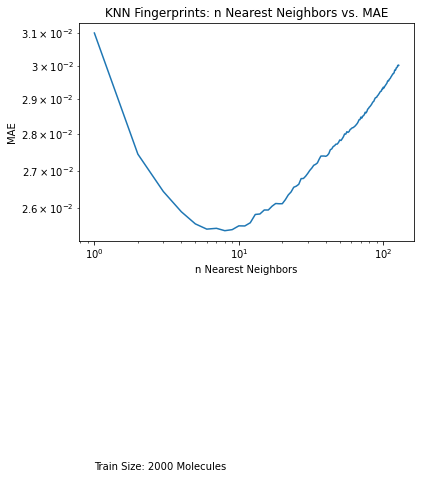

In [30]:
fig, ax = plt.subplots()
    
    
ax.loglog(mf_results['n_neighbors'], mf_results['mae'])
    
ax.set_title('KNN Fingerprints: n Nearest Neighbors vs. MAE')
ax.text(1, 2*(10**-2), 'Train Size: 2000 Molecules')
    

ax.set_xlabel('n Nearest Neighbors')
ax.set_ylabel('MAE')

## Q2-1

*Explain why the MAE improves when increasing from 1 and then worsens as you increase past 2<sup>4</sup>*

When the n neighbors is set too low the data is overfitted as too many nearest neighbors are being used by the model to calculate a prediction. After we surpass 2<sup>4</sup> nearest neighbors, the KNN model makes the predicted data too smooth thus leading to underfitting.

---

Add a step in the model Pipeline from Step 1 that uses **Recursive Feature Elimination** with a **Random Forest model** to reduce the number of **features to 32** in 4 steps

In [28]:
#Retraining KNN with RFE
mf_train_data, mf_test_data = train_test_split(data, test_size=0.92)
mf_model2 = Pipeline([
    ('fingerprint', MorganFingerprintTransformer()),
    ('rfe', RFE(estimator=RandomForestRegressor(random_state = 0, n_jobs=-1), n_features_to_select=32, step=4)),
    ('knn', KNeighborsRegressor(metric='jaccard', n_jobs=-1))
    
])

mf_results2 = []

for i in tqdm(range(0,8)):
            n=(2**i)
            mf_model2.set_params(knn__n_neighbors=n)
 
            # Train and test the model
            mf_model2.fit(mf_train_data['smiles_0'], mf_train_data['bandgap'])
            mf_y_pred = mf_model2.predict(mf_test_data['smiles_0'])

            # Store the results
            #  Use a list of dictionaries, which I can convert to 
            #  a DataFrame very easily
            mf_results2.append({
                'n_neighbors': n,
                'train_size': 2000,
                'r2_score': r2_score(mf_test_data['bandgap'], mf_y_pred),
                'mae': mean_absolute_error(mf_test_data['bandgap'], mf_y_pred)
            })
            
mf_results2 = pd.DataFrame(mf_results2)  # Converts to a dataframe

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [09:07<00:00, 68.38s/it]


Compare the **MAE** versus **number of neighbors** to kNN without feature selection

Text(0, 0.5, 'MAE')

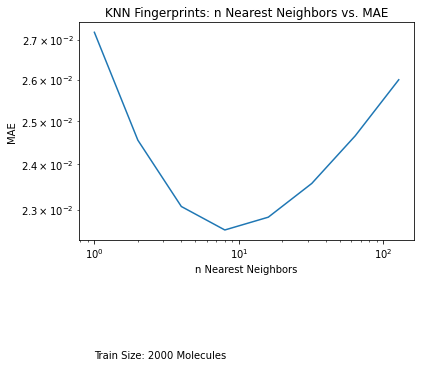

In [31]:
fig, ax = plt.subplots()
    
    
ax.loglog(mf_results2['n_neighbors'], mf_results2['mae'])
    
ax.set_title('KNN Fingerprints: n Nearest Neighbors vs. MAE')
ax.text(1, 2*(10**-2), 'Train Size: 2000 Molecules')
    

ax.set_xlabel('n Nearest Neighbors')
ax.set_ylabel('MAE')

## Q2-3

*Why would the model with the feature selection perform better? In general terms, explain the disadvantage of using a general-purpose distance metrics such as fingerprints and how must one must account for that.*

General purpose distance are very susceptible to outlier datapoints which will fold errors into the classifications of the models. In order to account for this, we use feature selection to reduce the dataset only to points that will contribute to enforcing the model's trends/classifications.